# Media Bias Text Generation Transformer

> A glimpse at a few outputs of the Text Generation Transformer project

- toc: true 
- badges: true
- comments: true
- author: Isaac Flath
- categories: [Neural Networks]

# Goals

### Project Goals

**Gain Competence doing Text Generation using transformers**

I wanted to learn a bit more about text generation, and these transformers that are taking over text generation.  I chose to work with GPT2, and found that the HuggingFace transformers and library came very highly recommended.

**Get a glimpse in differences in bias from different media sources**

I have recently been reading news from several media sources, and I am often astounded by the differences.  What I wanted to do, is take a pre-trained model and fine tune it on a specific media source.  Do this several times on different sources and compare.  In what ways will my models be biased by their source?  One might hypothesise that this would show some of the biases that people may be nudged toward by only consuming that media source.


### Article Goals

The purpose of this article is just to show some of the outputs and get people thinking about how an approach like this could be interesting and useful to study further.  The bulk of the project was on setting up and fine-tuning transformers, which is not at all what this article is about.  This article is about looking at some of the outputs in order to spur additional thought on the topic

# Prompt Examples

Let's start by looking at a couple prompts to see how we might compare them manually.  We will take a look at a coupe of examples.

### Scientists

In this case, the models were each given the prompt "The reason Scientists do press briefings is".  Can you spot the outlier?

> **CNBC:** The reason Scientists do press briefings is because they want to know what's going on in the world," he said. "If you don't have a clear understanding of where things are, it can be very difficult for scientists to get their work done.<br/><br/>**CNN:** The reason Scientists do press briefings is because they want to know what's going on in the world," he said. "They're trying to get a sense of where things are."<br/><br/>**Fox News:** The reason Scientists do press briefings is because they're trying to find out more about what the Russians are up to<br/><br/>**The New York Times:** The reason Scientists do press briefings is that it’s a way for them to get the most out of their time<br/><br/>**Washington Post:** The reason Scientists do press briefings is because they’re the only ones who know what's going on. 

### Antifa

Another area where there's quite a bit of contrast is Antifa.  Which one doesn't match the others?

> **CNBC:** Antifa is a group that has been active in the U.S. for more than 50 years, according to its website. "We are committed to protecting our community from violence and hate," it says on its website.<br/><br/>**CNN:** Antifa is a group that advocates for the rights of people to peacefully assemble, organize and participate in peaceful protests.<br/><br/>**Fox News:** Antifa is a group that's trying to take down the president of the United States. And so, I don't think it's going to be easy for them to come in and do what they want to do.<br/><br/>**The New York Times:** Antifa is a group that has been active since the beginning of the year, and it's not clear how many people have joined. <br/><br/>**Washington Post:** Antifa is a group that advocates for the rights of women and girls to self-identify as LGBTQ, according to its website.

### Closing

Now it's fairly entertaining to read through the ones that really demonstrate bias, like this one:

> **Fox News:** The thing we should do with immigrants is make sure that they're not coming to the United States illegally. (END VIDEO CLIP) INGRAHAM: Well, I don't know if you have a lot of sympathy for those who are trying to come into this country as unaccompanied minors or people in their 20s and 30s being separated from their parents because it seems like every single one of them has some kind of criminal record which makes us all very worried about these kids crossing our southern border at any given time. 


and to read zingers like this one

> **CNBC:** The most hated politician is Donald Trump, and he's got a lot of problems


and run across snippets like this

> "The landmark summit between North Korean leader Kim Jong Un and dictator-in-waiting Donald Trump"


But that's a pretty biased way of analyzing things.  So instead let's look at overall word counts and see if there is a difference in word choice between these models.

# Word Count

### Approach

I came up with a bunch of prompts and gave them to each model.  Now, I will count the number of times words appear to see if there are any differences in word choice between media sources.

### Get word counts for each group

In [1]:
#collapse-hide
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from collections import Counter

The first step is to read in the text file with text generated by the model (Go to that URL if you want to see more).

In [2]:
#collapse-show

df = pd.read_csv('https://raw.githubusercontent.com/Isaac-Flath/MediaBias/main/text_generated.csv',
            usecols=['source','prompt','text'])

We will then convert everything to lowercase and get rid of punctuation

In [3]:
#collapse-show

tokenizer = nltk.RegexpTokenizer(r"\w+")
df['text'] = df.text.str.lower().apply(tokenizer.tokenize)

Finally we count all the words and put it into a pandas data frame for convenience

In [4]:
#collapse-show

results = Counter()
df['text'].apply(results.update)

results = pd.concat([pd.DataFrame.from_dict(results.keys()),pd.DataFrame.from_dict(results.values())],axis=1)
results.columns = ['words','all_cnt']

Now, we repeat this same thing for each media source so we have word counts for each source (ie CNN)

In [5]:
#collapse-show
for s in df.source.unique():
  tempdf = df[df.source==s].copy()
  tempcntr = Counter()
  tempdf['text'].apply(tempcntr.update)
  tempresults = pd.concat([pd.DataFrame.from_dict(tempcntr.keys()),pd.DataFrame.from_dict(tempcntr.values())],axis=1)
  tempresults.columns = ['words',s.replace(' ','')+'_cnt']
  results = pd.merge(results,tempresults, how = 'left', on = 'words')
results.fillna(0,inplace=True)

In [6]:
results.head()

words  all_cnt  CNBC_cnt  CNN_cnt  FoxNews_cnt  TheNewYorkTimes_cnt  \
0  blockchain        7       1.0      2.0          2.0                  1.0   
1          is      276      50.0     54.0         55.0                 58.0   
2           a      592     125.0    138.0         91.0                141.0   
3  technology       12       4.0      2.0          2.0                  2.0   
4        that      513      92.0    105.0         92.0                106.0   

   WashingtonPost_cnt  
0                 1.0  
1                59.0  
2                97.0  
3                 2.0  
4               118.0

### Exclude stop words

We don't really care about some words.  For example, if one station uses "the" a bit more that doesn't mean much to me.  So let's remove stop words.

Conveniently nltk has a list of english stop words already put together.

In [7]:
print(stopwords.words('english')[:5])

['i', 'me', 'my', 'myself', 'we']


Now let's use that to filter out dataframe for all stop words, as well as sort it in descending order so the most common words are at the top.

In [8]:
results = results[~results.words.isin(stopwords.words('english'))].copy()
results.sort_values('all_cnt',ascending=False, inplace=True)

### Frequency Graphs

Let's graph the amount the count deviates from the average and see if there is any point looking further.  If these are all close to blank graphs (no deviation from average) then that means the text they generated uses almost the same words.

In this case, we can see that they all deviate in different ways on different words.  So **the media source impacted the models word choice**

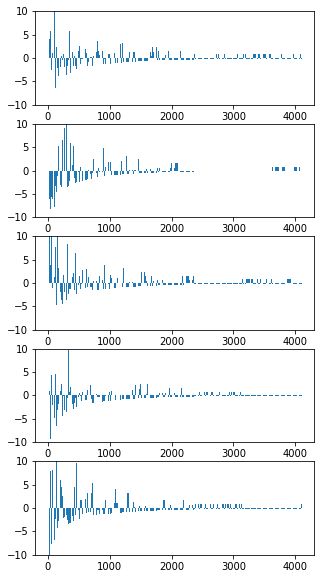

In [9]:
#collapse-show
width, indexes = 0.7, np.arange(len(results))

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,figsize=(5,10))

ax_map = [(ax1,results.CNBC_cnt),(ax2,results.FoxNews_cnt),(ax3,results.CNN_cnt),
 (ax4,results.TheNewYorkTimes_cnt),(ax5,results.WashingtonPost_cnt)]  

for x in ax_map:
  x[0].set_title = x[1].name
  x[0].bar(indexes,x[1]-results.all_cnt/5,width)
  x[0].set_ylim(-10,10)

plt.show()